**Hamidreza Amirzadeh**

Group 3

Augmenting Hala-Khorshid sentiment analysis dataset using ParsBert pre-trained model
____
____

In [1]:
!pip install transformers --quiet

In [ ]:
!pip install datasets --quiet

In [ ]:
!pip install accelerate --quiet

We use parsbert model to fine-tune on our dataset:

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch


model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

text = "[MASK] خیلی خوبی بود."

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'{text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

'بازی خیلی خوبی بود.'
'بازیکن خیلی خوبی بود.'
'روز خیلی خوبی بود.'
'شروع خیلی خوبی بود.'
'تیم خیلی خوبی بود.'


____

# Loading dataset and preprocessing to do Un-Conditional MLM

In [ ]:
import pandas as pd

df = pd.read_csv('pre-proc-data.csv')
df = df[['comment','sentiment']]
df['comment'] = df['comment'].apply(lambda x: str(x))
# add number of tokens in a new column
df['num_tok'] = df['comment'].apply(lambda x: len(x.split()))
df.head()

,comment,sentiment,num_tok
0,آقای رشیدپور من تا هفته NUM۲ بچه‌ام پسر بود و ...,1,31
1,چقدر این دزد باحال بود,1,5
2,سلام اگر ممکنه از کلمه سی تی اسکن تو برنامتون ...,-1,19
3,شما پول اینترنتت و گوشیت رو هزینه بچت کن,0,9
4,آقای رشید پور به روستای ما بن گوشت یخ زده دادن...,-1,24


In [ ]:
len(df)

8335

In [ ]:
sum(df['num_tok'] == 0) + sum(df['num_tok'] == 1) + sum(df['num_tok'] == 2)
# we want to remove these comments thas has below 3 tokens

1127

In [ ]:
# remove comments with below 3 tokens
df.drop(df[df['num_tok'] < 3].index, inplace = True)
len(df)

7208

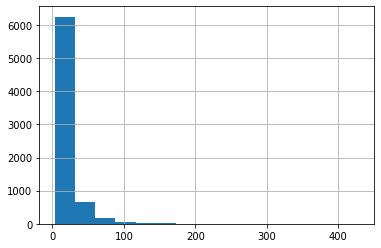

In [ ]:
df['num_tok'].hist(bins=15)

In [ ]:
df['sentiment'].value_counts()

-1    2975
 1    2354
 0    1879
Name: sentiment, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=1)

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
from datasets.dataset_dict import DatasetDict
khorshid_dataset = DatasetDict({'train':train_dataset, 'test':test_dataset})
khorshid_dataset

DatasetDict({
    train: Dataset({
        features: ['comment', 'sentiment', 'num_tok', '__index_level_0__'],
        num_rows: 6487
    })
    test: Dataset({
        features: ['comment', 'sentiment', 'num_tok', '__index_level_0__'],
        num_rows: 721
    })
})

In [ ]:
sample = khorshid_dataset["train"].shuffle().select(range(3))

for row in sample:
    print(f"\n'---> Review: {row['comment']}'")
    print(f"'---> Label: {row['sentiment']}'")


'>>> Review: میشه بپرسین چه جوری تشنج میکرد؟؟'
'>>> Label: 0'

'>>> Review: برام جالب بود امروز توبرنامتون نام شهرمون ارسک خراسان جنوبی روگفتید ولی آقای رشیدپور تلفظش اشتباه بود ارسک صحیحه ارسک خراسان جنوبی با آب وهوای عالی وبهاری زیبا'
'>>> Label: -1'

'>>> Review: جناب آ قای رشیدپور عزیز'
'>>> Label: 0'


In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["comment"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = khorshid_dataset.map(tokenize_function, batched=True, remove_columns=["comment", "sentiment", "num_tok" ,"__index_level_0__"])

tokenized_datasets

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 6487
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 721
    })
})

In [ ]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'Comment {idx} length: {len(sample)}'")

'Comment 0 length: 25'
'Comment 1 length: 67'
'Comment 2 length: 13'


In [ ]:
# concatenate all these examples 
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'Concatenated reviews length: {total_length}'")

'Concatenated reviews length: 105'


now let’s split the concatenated reviews into chunks of the size given by block_size. To do so, we iterate over the features in concatenated_examples and use a list comprehension to create slices of each feature. The result is a dictionary of chunks for each feature:

Copied


In [ ]:
chunk_size = 32

chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"' Chunk length: {len(chunk)}'")

' Chunk length: 32'
' Chunk length: 32'
' Chunk length: 32'
' Chunk length: 9'


In [ ]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4558
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 513
    })
})

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

'که ۹ماه پیش ثبت نام کردیم دو ماه از تحویل ماشین مبگذره ولی هنوز خبری نیست هر بار زنگ میزنیم کسی جواب گو نیست نه ماه پیش سکه یک میلیون'

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["labels"])

'که ۹ماه پیش ثبت نام کردیم دو ماه از تحویل ماشین مبگذره ولی هنوز خبری نیست هر بار زنگ میزنیم کسی جواب گو نیست نه ماه پیش سکه یک میلیون'

## Fine-tuning Un-Conditioned model using 🤗Tranier

we need a special data collator that can randomly mask some of the tokens in each batch of texts.

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(1,3)]
# remove word_ids
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n' {tokenizer.decode(chunk)}'")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



' که ۹ماه پیش ثبت نام کردیم [MASK] ماه از تحویل ماشین مبگذره [MASK] هنوز خبری [MASK] هر [MASK] زنگ میزنیم کسی جواب گو نیست نه ماه پیش سکه یک میلیون'

' [MASK] صد [MASK] [MASK] با پولی که به سایپا دادیم [MASK] num۲ تا سکه [MASK] یا [MASK] موقع قیمت [MASK] استپ منتشرکنندگان num۲ میلیون بود [SEP] [CLS] وزیر ک جوابگو'


In [ ]:
print(tokenizer.decode(lm_datasets['train']['input_ids'][1]))
print(tokenizer.decode(lm_datasets['train']['input_ids'][2]))

که ۹ماه پیش ثبت نام کردیم دو ماه از تحویل ماشین مبگذره ولی هنوز خبری نیست هر بار زنگ میزنیم کسی جواب گو نیست نه ماه پیش سکه یک میلیون
و صد بود میشد با پولی که به سایپا دادیم حدود num۲ تا سکه بخری یا همون موقع قیمت بازار استپ وی num۲ میلیون بود [SEP] [CLS] وزیر ک جوابگو


the [MASK] token has been randomly inserted at various locations in our text. These will be the tokens which our model will have to predict during training.

In [ ]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4558
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 513
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from transformers import TrainingArguments

batch_size = 16
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-khorshid",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    logging_steps=logging_steps,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid into local empty directory.


**Evaluation method in masked language modeling:**

Given the test set to the model, it should assign high probabilities to these grammatical coorect sentences, so we need to measure the perplexity of the model. There are various mathematical definitions of perplexity, but the one we’ll use defines it as the exponential of the cross-entropy loss.

In [ ]:
import math

eval_results = trainer.evaluate()
print(f" Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16


 Perplexity: 246.22


we see that before fine-tuning the model, it's perplexity on test set is relatively high which is the sign of the bad performance of the model.

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4558
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 855
  Number of trainable parameters = 162942880


Epoch,Training Loss,Validation Loss
1,4.773300,4.436894
2,4.287500,4.307038
3,4.132000,4.190840


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16


Saving model checkpoint to bert-base-parsbert-uncased-finetuned-khorshid/checkpoint-500
Configuration saved in bert-base-parsbert-uncased-finetuned-khorshid/checkpoint-500/config.json
Model weights saved in bert-base-parsbert-uncased-finetuned-khorshid/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-parsbert-uncased-finetuned-khorshid/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased-finetuned-khorshid/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bert-base-parsbert-uncased-finetuned-khorshid/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased-finetuned-khorshid/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 51

TrainOutput(global_step=855, training_loss=4.395611471878855, metrics={'train_runtime': 213.2199, 'train_samples_per_second': 64.131, 'train_steps_per_second': 4.01, 'total_flos': 225123821236224.0, 'train_loss': 4.395611471878855, 'epoch': 3.0})

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16


>>> Perplexity: 64.97


We see that the perplexity of the model after fine-tuning has effectively decreased.

In [ ]:
# trainer.push_to_hub()

Saving model checkpoint to bert-base-parsbert-uncased-finetuned-khorshid
Configuration saved in bert-base-parsbert-uncased-finetuned-khorshid/config.json
Model weights saved in bert-base-parsbert-uncased-finetuned-khorshid/pytorch_model.bin
tokenizer config file saved in bert-base-parsbert-uncased-finetuned-khorshid/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased-finetuned-khorshid/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/622M [00:00<?, ?B/s]

Upload file runs/Jan12_15-40-52_3fb2fcfcb50b/events.out.tfevents.1673538328.3fb2fcfcb50b.328.2: 100%|#########…

Upload file runs/Jan12_15-40-52_3fb2fcfcb50b/events.out.tfevents.1673538087.3fb2fcfcb50b.328.0:  60%|#####9   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid
   afccbd6..b1b52cd  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid
   afccbd6..b1b52cd  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Masked Language Modeling', 'type': 'fill-mask'}}
To https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid
   b1b52cd..f935e64  main -> main

   b1b52cd..f935e64  main -> main



'https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid/commit/b1b52cd2354ecfee72454e6a40f812c0c1f45602'

## Full training and using 🤗Accelartor

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = model_checkpoint.split("/")[-1]
model_name = f"{model_name}-finetuned-khorshid-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid-accelerate'

In [ ]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid-accelerate into local empty directory.


In [ ]:
from torch.utils.data import DataLoader

lm_datasets['train'] = lm_datasets['train'].remove_columns('word_ids')
lm_datasets['test'] = lm_datasets['test'].remove_columns('word_ids')

train_dataloader = DataLoader(lm_datasets['train'], shuffle=True, batch_size=16, collate_fn=data_collator)
eval_dataloader = DataLoader(lm_datasets['test'], batch_size=16, collate_fn=data_collator)

In [ ]:
for batch in train_dataloader:
  break

{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([16, 32]),
 'token_type_ids': torch.Size([16, 32]),
 'attention_mask': torch.Size([16, 32]),
 'labels': torch.Size([16, 32])}

In [ ]:
from transformers import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs*len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
device

device(type='cuda')

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

batch_size = 16
num_train_epochs = 3

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(lm_datasets['test'])]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f"---> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/855 [00:00<?, ?it/s]

---> Epoch 0: Perplexity: 68.36507526531248
---> Epoch 1: Perplexity: 75.70655279592064


Several commits (2) will be pushed upstream.


---> Epoch 2: Perplexity: 71.50765291093626


In [ ]:
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid-accelerate/commit/e59c7f79d50d691e62535eaa5f72cb51d14d7ea5', commit_message='Upload BertForMaskedLM', commit_description='', oid='e59c7f79d50d691e62535eaa5f72cb51d14d7ea5', pr_url=None, pr_revision=None, pr_num=None)

## use the model

In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid"
)

Downloading:   0%|          | 0.00/652 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Hamid-reza--bert-base-parsbert-uncased-finetuned-khorshid/snapshots/cac7415a27f42435cd506f11f82fe391717dd3bd/config.json
Model config BertConfig {
  "_name_or_path": "Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Hamid

Downloading:   0%|          | 0.00/652M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Hamid-reza--bert-base-parsbert-uncased-finetuned-khorshid/snapshots/cac7415a27f42435cd506f11f82fe391717dd3bd/pytorch_model.bin
All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.


Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--Hamid-reza--bert-base-parsbert-uncased-finetuned-khorshid/snapshots/cac7415a27f42435cd506f11f82fe391717dd3bd/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Hamid-reza--bert-base-parsbert-uncased-finetuned-khorshid/snapshots/cac7415a27f42435cd506f11f82fe391717dd3bd/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--Hamid-reza--bert-base-parsbert-uncased-finetuned-khorshid/snapshots/cac7415a27f42435cd506f11f82fe391717dd3bd/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Hamid-reza--bert-base-parsbert-uncased-finetuned-khorshid/snapshots/cac7415a27f42435cd506f11f82fe391717dd3bd/tokenizer_config.json


In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f" {pred['sequence']}")

 برنامه خیلی خوبی بود.
 خیلی خیلی خوبی بود.
 مجری خیلی خوبی بود.
 بازیگر خیلی خوبی بود.
 مرد خیلی خوبی بود.


In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid-accelerate"
)

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f" {pred['sequence']}")

 برنامه خیلی خوبی بود.
 روز خیلی خوبی بود.
 خیلی خیلی خوبی بود.
 سکانس خیلی خوبی بود.
 خبر خیلی خوبی بود.


We see that the fine-tuning was successful and the parsbert model was appropriately adopted to our dataset. since the first model had slightly less perplexity, we use that so on.


## Data augmentation using the un-conditioned fine-tuned model

In [ ]:
import numpy as np
import random
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid')
model = BertForMaskedLM.from_pretrained('Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid')

def generate(comment, num_gen=5, msk_rate=0.15):

    new_comments = []  # Output

    commnet_list = comment.split()
    num_toks = len(commnet_list)
    num_masks = int(np.ceil(msk_rate * num_toks))

    msk_idx = random.sample(range(num_toks), num_masks)
    for idx in msk_idx:
      commnet_list[idx] = '[MASK]'
      
    text = ' '.join(commnet_list)
    
    inputs = tokenizer(text, return_tensors='pt')
    
    outputs = model(**inputs)
    predictions = outputs[0]

    sorted_preds, sorted_idx = predictions[0].sort(dim=-1, descending=True)
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

    for k in range(num_gen):
        predicted_index = [sorted_idx[i, k].item() for i in mask_token_index]
        new_ids = []
        j = 0
        for id in tokenizer.encode(text)[1:-1]:
          if id != tokenizer.mask_token_id:
            new_ids.append(id)
          else:
            new_ids.append(predicted_index[j])
            j += 1
        new_comments.append(tokenizer.decode(new_ids))

    return new_comments

In [ ]:
sample_txt = df_test['comment'].sample(1).iloc[0]
print('Original : ', sample_txt)
print('\n')
print('Generated : ', generate(sample_txt)[0])

Original :  با سلام خو شحالم از شروع دوباره حالا خورشید با حضور اقای رشید پور


Generated :  با سلام خو شحالم از برنامه دوباره حالا خورشید با حضور اقای رشید پور


In [ ]:
df_gen_uncond = df_test.sample(100)  # we choose 100 random comments from test set to augment them
num_gen=5
msk_rate=0.15
df_gen_uncond['gen_comment'] = df_gen_uncond['comment'].apply(lambda x: generate(x, num_gen, msk_rate)[random.randint(0,num_gen-1)])
df_gen_uncond = df_gen_uncond[['comment', 'gen_comment', 'sentiment']]

In [ ]:
df_gen_uncond.head()

,comment,gen_comment,sentiment
7415,۱ عالیه برنامتون خسته نباشین ممنون,۱ عالیه برنامتون خسته نباشین ،,1
4559,پرفسور مریم میرزاخانی,پرفسور مریم طوسی,0
7052,سلام آقای رشید پور من کارمند یکی از پروژه‌های ...,سلام اقای رشید پور خودم کارمند یکی از پروژههای...,-1
5287,جناب رشیدپور گرامی روز مهندس رو بهتون تبریک می...,جناب رشیدپور گرامی روز مهندس رو خیلی تبریک عرض...,1
6662,سلام رضا رمضان زاده هستم خبری از ما نمیگیرید د...,سلام رضا رمضان پور هیچ خبری از ما نمیگیرید دیگ...,-1


In [ ]:
# df_gen_uncond.to_csv('./gen_uncond.csv')


______
# Loading dataset and preprocessing to do Conditional MLM

In [ ]:
df.head()

,comment,sentiment,num_tok
0,آقای رشیدپور من تا هفته NUM۲ بچه‌ام پسر بود و ...,1,31
1,چقدر این دزد باحال بود,1,5
2,سلام اگر ممکنه از کلمه سی تی اسکن تو برنامتون ...,-1,19
3,شما پول اینترنتت و گوشیت رو هزینه بچت کن,0,9
4,آقای رشید پور به روستای ما بن گوشت یخ زده دادن...,-1,24


In [ ]:
# convert sentiment column to string (in order to concatenate sentiment and comment)
df['sentiment'] = df['sentiment'].astype(str)

In [ ]:
# convert Latin sentiment numbers to persian numbers(since our tokenizer can't encode Latin numbers)
# Note that since we can't encode negative numbers, we add 1 to each sentiment number
def en2fa(sentiment):
  if sentiment == '1':
    return '۲'
  elif sentiment == '0':
    return '۱'
  elif sentiment == '-1':
    return '۰'

df['sentiment'] = df['sentiment'].apply(lambda x: en2fa(x))

Since adding the label names to the tokenizer vocabulary makes the training very slow, we won't add the labels to the vocabulary. in other words we used the **prepend** method.

In [ ]:
df['sen_com'] = df.apply(lambda x: x['sentiment'] + ' [SEP] ' + x['comment'], axis=1)

In [ ]:
df.drop(['comment', 'sentiment', 'num_tok'], axis=1, inplace=True)

In [ ]:
df.head()

,sen_com
0,۲ [SEP] آقای رشیدپور من تا هفته NUM۲ بچه‌ام پس...
1,۲ [SEP] چقدر این دزد باحال بود
2,۰ [SEP] سلام اگر ممکنه از کلمه سی تی اسکن تو ب...
3,۱ [SEP] شما پول اینترنتت و گوشیت رو هزینه بچت کن
4,۰ [SEP] آقای رشید پور به روستای ما بن گوشت یخ ...


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=1)

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
from datasets.dataset_dict import DatasetDict
khorshid_cond_dataset = DatasetDict({'train':train_dataset, 'test':test_dataset})
khorshid_cond_dataset

DatasetDict({
    train: Dataset({
        features: ['sen_com', '__index_level_0__'],
        num_rows: 7501
    })
    test: Dataset({
        features: ['sen_com', '__index_level_0__'],
        num_rows: 834
    })
})

In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["sen_com"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = khorshid_cond_dataset.map(tokenize_function, batched=True, remove_columns=["sen_com","__index_level_0__"])

tokenized_datasets

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 7501
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 834
    })
})

In [ ]:
chunk_size = 32

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 5172
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 567
    })
})

In [ ]:
tokenizer.decode(lm_datasets["train"][10]["input_ids"])

'link در این مورد هم صحبتی میشد تا در مورد وضعیت این مراکز بازنگری و اقدامی صورت بگیره. [SEP] [CLS] ۰ [SEP] ۲ - خیییر [SEP] [CLS] ۰ [SEP] تو'

## Fine-tuning Conditioned model using 🤗Tranier

we need a special data collator that can randomly mask some of the tokens in each batch of texts.

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(9,11)]
# remove word_ids
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n' {tokenizer.decode(chunk)}'")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



' که مسيول بایات یکی از مهمترین قشرهای جامعه هستند و ایندهی جامعه رو تا حد زیادی میشه وابسته به اونها [MASK]ست ولی از لحاظ کیفیت اموزشی و امکانات سطح خیلی [MASK]'

' [MASK] در [MASK] مورد هم صحبتی [MASK] [MASK] در مورد وضعیت این مراکز بازنگری و اقدامی صورت بگیره. [SEP] [CLS] ۰ [SEP] ۲ - [MASK] [MASK] [SEP] [CLS] ۰ [SEP] [MASK]'


In [ ]:
print(tokenizer.decode(lm_datasets['train']['input_ids'][9]))
print(tokenizer.decode(lm_datasets['train']['input_ids'][10]))

که مسيول پرورش یکی از مهمترین قشرهای جامعه هستند و ایندهی جامعه رو تا حد زیادی میشه وابسته به اونها دونست ولی از لحاظ کیفیت اموزشی و امکانات سطح خیلی پایینی
link در این مورد هم صحبتی میشد تا در مورد وضعیت این مراکز بازنگری و اقدامی صورت بگیره. [SEP] [CLS] ۰ [SEP] ۲ - خیییر [SEP] [CLS] ۰ [SEP] تو


the [MASK] token has been randomly inserted at various locations in our text. These will be the tokens which our model will have to predict during training.

In [ ]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 5172
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 567
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from transformers import TrainingArguments

batch_size = 16
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-conditioned-khorshid",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    logging_steps=logging_steps,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid into local empty directory.


**Evaluation method in masked language modeling:**

Given the test set to the model, it should assign high probabilities to these grammatical coorect sentences, so we need to measure the perplexity of the model. There are various mathematical definitions of perplexity, but the one we’ll use defines it as the exponential of the cross-entropy loss.

In [ ]:
import math

eval_results = trainer.evaluate()
print(f" Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 16


 Perplexity: 304.65


we see that before fine-tuning the model, it's perplexity on test set is relatively high which is the sign of the bad performance of the model.

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5172
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 972
  Number of trainable parameters = 162942880


Epoch,Training Loss,Validation Loss
1,4.599400,4.392967
2,4.134900,4.209049
3,3.981200,4.028193


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 16


Saving model checkpoint to bert-base-parsbert-uncased-finetuned-conditioned-khorshid/checkpoint-500
Configuration saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/checkpoint-500/config.json
Model weights saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  yo

TrainOutput(global_step=972, training_loss=4.237852508639112, metrics={'train_runtime': 240.2856, 'train_samples_per_second': 64.573, 'train_steps_per_second': 4.045, 'total_flos': 255449847177216.0, 'train_loss': 4.237852508639112, 'epoch': 3.0})

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 16


>>> Perplexity: 65.02


We see that the perplexity of the model after fine-tuning has effectively decreased.

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-parsbert-uncased-finetuned-conditioned-khorshid
Configuration saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/config.json
Model weights saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/pytorch_model.bin
tokenizer config file saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/tokenizer_config.json
Special tokens file saved in bert-base-parsbert-uncased-finetuned-conditioned-khorshid/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/622M [00:00<?, ?B/s]

Upload file runs/Jan13_10-48-50_a18103ec555b/events.out.tfevents.1673607214.a18103ec555b.403.2: 100%|#########…

Upload file runs/Jan13_10-48-50_a18103ec555b/events.out.tfevents.1673606958.a18103ec555b.403.0:  60%|#####9   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid
   7e5a941..6b3e478  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid
   7e5a941..6b3e478  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Masked Language Modeling', 'type': 'fill-mask'}}
To https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid
   6b3e478..e868ec4  main -> main

   6b3e478..e868ec4  main -> main



'https://huggingface.co/Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid/commit/6b3e478a83469efcd4395ab6cd940bd04d29a1d9'

## Data augmentation using conditioned fine-tuned model

In [ ]:
import numpy as np
import random
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid')
model = BertForMaskedLM.from_pretrained('Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid')

def generate(comment, num_gen=5, msk_rate=0.15):

    new_comments = []  # Output

    commnet_list = comment.split()
    num_toks = len(commnet_list)
    # num_masks = int(np.ceil(msk_rate * num_toks))
    num_masks = max(1, int(np.floor(msk_rate * num_toks)))

    # we don't want to mask the label and [SEP] tokens, so we set the starting point of the below range to 2
    msk_idx = random.sample(range(2, num_toks), num_masks)
    for idx in msk_idx:
      commnet_list[idx] = '[MASK]'
      
    text = ' '.join(commnet_list)
    
    inputs = tokenizer(text, return_tensors='pt')
    
    outputs = model(**inputs)
    predictions = outputs[0]

    sorted_preds, sorted_idx = predictions[0].sort(dim=-1, descending=True)
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

    for k in range(num_gen):
        predicted_index = [sorted_idx[i, k].item() for i in mask_token_index]
        new_ids = []
        j = 0
        for id in tokenizer.encode(text)[1:-1]:
          if id != tokenizer.mask_token_id:
            new_ids.append(id)
          else:
            new_ids.append(predicted_index[j])
            j += 1
        new_comments.append(tokenizer.decode(new_ids))

    return new_comments

In [ ]:
sample_txt = df_test['sen_com'].sample(1).iloc[0]
print('Original : ', sample_txt)
print('\n')
print('Generated : ', generate(sample_txt)[0])

Original :  ۰ [SEP] سلام رضا رمضان زاده هستم خبری از ما نمیگیرید دیگه اقای رشید پور چی شد اخر جایزه منو ندادیا


Generated :  ۰ [SEP] من رضا رمضان پور هستم خبری از ما نمیگیرید دیگه اقای رشید پور چی شد اخر جایزه منو ندادیا


In [ ]:
df_gen_cond = df_test.sample(100)  # we choose 100 random comments from test set to augment them
num_gen=5
msk_rate=0.15
df_gen_cond['gen_sen_com'] = df_gen_cond['sen_com'].apply(lambda x: generate(x, num_gen, msk_rate)[random.randint(0,num_gen-1)])  # we choose one the five generated comments

In [ ]:
df_gen_cond['comment'] = df_gen_cond['sen_com'].apply(lambda x: ' '.join(x.split()[2:]))
df_gen_cond['gen_comment'] = df_gen_cond['gen_sen_com'].apply(lambda x: ' '.join(x.split()[2:]))

def fa2en(sentiment):
  if sentiment == '۲':
    return 1
  elif sentiment == '۱':
    return 0
  elif sentiment == '۰':
    return -1

df_gen_cond['sentiment'] = df_gen_cond['sen_com'].apply(lambda x: fa2en(x.split()[0]))

df_gen_cond.drop(['sen_com', 'gen_sen_com'], axis=1, inplace=True)

In [ ]:
df_gen_cond.head()

,comment,gen_comment,sentiment
3845,انقلاب شدموسیقی سالن ازادی وغیره مخصوص آقایون ...,انقلاب شدموسیقی سالن ازادی صندلی مخصوص شروع شد...,-1
2125,با سلام خو شحالم از شروع دوباره حالا خورشید با...,با سلام خو شحالم از شروع دوباره برنامه خورشید ...,1
1642,چرا سریال کم درست شده قرار بود بیشتر باشه چرا ...,چرا سریال برف شروع شده قرار بود بیشتر باشه چرا...,-1
2111,زنده باشید آقای تنابنده واقعا عالی هستید,زنده باشید اقای تنابنده واقعا عالی هستید,1
4542,جناب آقایان، رضارشید پور و مهران مدیری,از اقایان ، رضارشید پور و مهران مدیری,0


In [ ]:
# df_gen_cond.to_csv('./gen_cond.csv')

As we discussed earlier we used the prepend method(label names were not added to the vocabluary). This method has lower accuracy than the expand method in which the labels are added to the vocabluary, but it has very slow training.

## Bonus: use spacial tokens to mask

It's likely to get better result if we mask more informative tokens such as name entities, adjectives, verbs and so on.

In [ ]:
!pip install hazm

In [ ]:
import numpy as np
import random
from transformers import BertTokenizer, BertForMaskedLM
from hazm import POSTagger

tagger = POSTagger(model='postagger.model')

tokenizer = BertTokenizer.from_pretrained('Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid')
model = BertForMaskedLM.from_pretrained('Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid')

def generate_bonus(comment, num_gen=5, msk_rate=0.15):

    new_comments = []  # Output

    commnet_list = comment.split()
    num_toks = len(commnet_list)
    # num_masks = int(np.ceil(msk_rate * num_toks))
    num_masks = max(1, int(np.floor(msk_rate * num_toks)))
    
    pos_tags = [x[1] for x in tagger.tag(commnet_list)]

    # we don't want to mask the label and [SEP] tokens, so we set the starting point of the below range to 2
    msk_idx = random.sample(range(2, num_toks), num_masks)
    i = 0
    iter = 0
    while iter<100 and i<num_masks:
      iter += 1
      msk_id = random.sample(range(2, num_toks), 1)[0]
      if pos_tags[msk_id] in ['Ne', 'AJ', 'AJe', 'AJe', 'V']:
        msk_idx[i] = msk_id
        i += 1
      else:
        continue


    for idx in msk_idx:
      commnet_list[idx] = '[MASK]'
      
    text = ' '.join(commnet_list)
    
    inputs = tokenizer(text, return_tensors='pt')
    
    outputs = model(**inputs)
    predictions = outputs[0]

    sorted_preds, sorted_idx = predictions[0].sort(dim=-1, descending=True)
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

    for k in range(num_gen):
        predicted_index = [sorted_idx[i, k].item() for i in mask_token_index]
        new_ids = []
        j = 0
        for id in tokenizer.encode(text)[1:-1]:
          if id != tokenizer.mask_token_id:
            new_ids.append(id)
          else:
            new_ids.append(predicted_index[j])
            j += 1
        new_comments.append(tokenizer.decode(new_ids))

    return new_comments

In [ ]:
sample_txt = df_test['sen_com'].sample(1).iloc[0]
print('Original : ', sample_txt)
print('\n')
print('Generated : ', generate_bonus(sample_txt)[0])

Original :  ۲ [SEP] سلام خوش امدن خیلی دلتنگتان شده_بودیم


Generated :  ۲ [SEP] سلام خوش امدن خیلی دلتنگتان هستیم


In [ ]:
df_gen_cond_bonus = df.sample(100)  # we choose 100 random comments to augment them
num_gen=5
msk_rate=0.15
df_gen_cond_bonus['gen_sen_com'] = df_gen_cond_bonus['sen_com'].apply(lambda x: generate_bonus(x, num_gen, msk_rate)[random.randint(0,num_gen-1)])  # we choose one of the five generated comments randomly

In [ ]:
df_gen_cond_bonus['comment'] = df_gen_cond_bonus['sen_com'].apply(lambda x: ' '.join(x.split()[2:]))
df_gen_cond_bonus['gen_comment'] = df_gen_cond_bonus['gen_sen_com'].apply(lambda x: ' '.join(x.split()[2:]))

def fa2en(sentiment):
  if sentiment == '۲':
    return 1
  elif sentiment == '۱':
    return 0
  elif sentiment == '۰':
    return -1

df_gen_cond_bonus['sentiment'] = df_gen_cond_bonus['sen_com'].apply(lambda x: fa2en(x.split()[0]))

df_gen_cond_bonus.drop(['sen_com', 'gen_sen_com'], axis=1, inplace=True)

In [ ]:
df_gen_cond_bonus.head()

,comment,gen_comment,sentiment
1446,نه_ به_ تجزیه_ کازرون#,نه [UNK]ی تجزیه [UNK] کازرون [UNK],-1
5561,مازندگی LINK زنده‌ایم,اقای link زندهایم,0
977,۸۵ درصد داوطلبان باتاثیر قطعی مخالفند میزان را...,۸۵ درصد درصد باتاثیر قطعی معدل میزان رای ملت ا...,0
5042,ای کاش همه‌ی کاراشون مثل بقیه تو دنیا بود اول ...,ای کاش همهی کاراشون مثل همیشه تو دنیا بود اول ...,-1
1794,آقای تنابنده تولدتون مبارک باشه. هزاران سال سل...,اقای تنابنده تولدت مبارک باشه. هزاران سال سلام...,1


In [ ]:
# df_gen_cond_bonus.to_csv('./gen_cond_bonus.csv')

# Data augmentation evaluation

## Un-Conditioned model

### compute and compare perplexity

In [2]:
def p_score(model, tokenizer, sentence):
    tensor_input = tokenizer.encode(sentence, return_tensors='pt')
    repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())

In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

model_name = 'Hamid-reza/bert-base-parsbert-uncased-finetuned-khorshid'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
import pandas as pd

df_gen_uncond = pd.read_csv('gen_uncond.csv')

In [7]:
# we choose 20 sample original and generated comments from df_gen_uncond to compute perplixty for them

df_ppx = df_gen_uncond.sample(20)
df_ppx['ppx_comment'] = df_ppx['comment'].apply(lambda x: p_score(sentence=x, model=model, tokenizer=tokenizer))
df_ppx['ppx_gen_comment'] = df_ppx['gen_comment'].apply(lambda x: p_score(sentence=x, model=model, tokenizer=tokenizer))

In [12]:
df_ppx.head()

,Unnamed: 0,comment,gen_comment,sentiment,ppx_comment,ppx_gen_comment
48,2990,اهل رمان نیستم,اهل دروغ نیستم,0,76.872434,69.592858
30,1694,چرا داعشیه از ده قدمی ماشین آرپیچی رو اشتباه زدن,چرا داعشیه از ده قدمی با ارپیچیو اشتباه زدن,0,2034.220437,6055.533957
45,7698,خیلی خاطره بدی بود من یک هفته جلو تلویزیون بود...,خیلی خاطره بدی بود که یک هفته جلو تلویزیون بود...,-1,45.739414,56.551459
99,1725,چرا نمیزارین همای سعادت حرف بزنه,چرا نمیزارین همای تنهایی حرف بزنه,-1,48.373517,108.623230
84,1687,لطفا بپرسید چرا اون داعشی‌ها یه تیر نزدن اصن ب...,لطفا بپرسید چرا اون مردم یه حرفی نزدن اصن بهتون ؟,0,520.238935,192.425648


In [14]:
df_ppx['ppx_comment'].describe()

count      20.000000
mean      441.181192
std      1098.431913
min         2.373814
25%        29.588737
50%        72.304067
75%       161.879795
max      4687.912079
Name: ppx_comment, dtype: float64

In [15]:
df_ppx['ppx_gen_comment'].describe()

count      20.000000
mean      395.488128
std      1333.924575
min         6.710451
25%        55.644643
50%        71.391275
75%       173.638190
max      6055.533957
Name: ppx_gen_comment, dtype: float64

### compute and compare diversity

In [46]:
import nltk, re, string, collections
from nltk.util import ngrams

def count_ngrams(corpus, n):
  tokenized = corpus.split()
  esBigrams = ngrams(tokenized, n)

  esBigramFreq = collections.Counter(esBigrams)
  return sum(list(esBigramFreq.values()))

In [57]:
# concatenate all comments from df_gen_cond

comments = ''
for c in df_gen_uncond['comment']:
  comments += c

gen_comments = ''
for c in df_gen_uncond['gen_comment']:
  gen_comments += c

In [58]:
count_ngrams(comments, 1) + count_ngrams(comments, 2)

2877

In [59]:
count_ngrams(gen_comments, 1) + count_ngrams(gen_comments, 2)

2857

## Conditioned model

### compute and compare perplexity

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

model_name = 'Hamid-reza/bert-base-parsbert-uncased-finetuned-conditioned-khorshid'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [62]:
import pandas as pd

df_gen_cond = pd.read_csv('gen_cond.csv')

In [63]:
# we choose 20 sample original and generated comments from df_gen_uncond to compute perplixty for them

df_ppx = df_gen_cond.sample(20)
df_ppx['ppx_comment'] = df_ppx['comment'].apply(lambda x: p_score(sentence=x, model=model, tokenizer=tokenizer))
df_ppx['ppx_gen_comment'] = df_ppx['gen_comment'].apply(lambda x: p_score(sentence=x, model=model, tokenizer=tokenizer))

In [64]:
df_ppx.head()

,Unnamed: 0,comment,gen_comment,sentiment,ppx_comment,ppx_gen_comment
63,6631,سلام و صبح شما بخیر و روز خوبی داشته_باشید با ...,سلام و صبح شما بخیر و روز خوبی داشته [UNK] باش...,1,38.931251,61.237598
42,828,همه شون رو به خدا سپردم من از حقم نمیگذرم اقای...,همه شون رو به خدا میگم میکنم از حقم نمیگذرم اق...,-1,9.454233,18.887695
93,943,نه به تاثیر سوابق تحصیلی,نسبت به تاثیر سوابق تحصیلی,-1,1.892485,1.699541
65,4584,فقط اقای رضا رشید پور,فقط فقط رضا رشید پور,0,10.940709,24.946528
33,3499,یعنی بهتر از رشیدپور نداریم اینقدر برنامه ش دو...,یعنی بهتر از رشیدپور نداریم و برنامه ش دوست دا...,1,106.971568,83.117651


In [65]:
df_ppx['ppx_comment'].describe()

count      20.000000
mean      279.049750
std       711.585956
min         1.892485
25%        17.410775
50%        49.498993
75%       116.326956
max      3103.820531
Name: ppx_comment, dtype: float64

In [66]:
df_ppx['ppx_gen_comment'].describe()

count     20.000000
mean      92.401215
std      103.713036
min        1.699541
25%       24.847310
50%       51.581230
75%      110.114254
max      364.721019
Name: ppx_gen_comment, dtype: float64

### compute and compare diversity

In [73]:
# concatenate all comments from df_gen_cond

comments = ''
for c in df_gen_cond['comment']:
  comments += c

gen_comments = ''
for c in df_gen_cond['gen_comment']:
  gen_comments += c

In [74]:
count_ngrams(comments, 1) + count_ngrams(comments, 2)

3465

In [75]:
count_ngrams(gen_comments, 1) + count_ngrams(gen_comments, 2)

3499

### Bonus generation

In [76]:
import pandas as pd

df_gen_cond_bonus = pd.read_csv('gen_cond_bonus.csv')

In [77]:
# we choose 20 sample original and generated comments from df_gen_uncond to compute perplixty for them

df_ppx = df_gen_cond_bonus.sample(20)
df_ppx['ppx_comment'] = df_ppx['comment'].apply(lambda x: p_score(sentence=x, model=model, tokenizer=tokenizer))
df_ppx['ppx_gen_comment'] = df_ppx['gen_comment'].apply(lambda x: p_score(sentence=x, model=model, tokenizer=tokenizer))

In [78]:
df_ppx.head()

,Unnamed: 0,comment,gen_comment,sentiment,ppx_comment,ppx_gen_comment
6,6922,مگر اقای رشید پور رئس جمهور که‌ تقاضا دارید,مگر اقای رشید پور ريس جمهور که تقاضا کرده,0,54.397430,46.114576
84,3731,ایناهم شدن خواننده,ایناهم که خواننده,-1,6811.400784,2083.211423
71,5960,گوه میخوری درباره مدیری حرف میزنی,گوه میخوری درباره مدیری حرفی میزنی,-1,473.548342,1252.330480
78,293,سید جمال تات. از قم. بعد از یک سال صبح ساعت NU...,سید جمال تات. از قم. بعد از یک سال صبح ساعت nu...,1,55.431032,51.014350
90,1780,از خانوم رامینفر حال اقای جعفری بپرسین بگین را...,از خانوم رامینفر حال نرگس جعفری بپرسین بگین را...,0,1221.427686,799.465033


In [79]:
df_ppx['ppx_comment'].describe()

count      20.000000
mean      810.809647
std      1831.953631
min         4.726127
25%        25.922114
50%        73.828926
75%       429.440148
max      6811.400784
Name: ppx_comment, dtype: float64

In [80]:
df_ppx['ppx_gen_comment'].describe()

count      20.000000
mean      522.319546
std      1088.065478
min         8.277450
25%        37.967421
50%        88.678481
75%       292.187107
max      4586.681321
Name: ppx_gen_comment, dtype: float64

In [81]:
# concatenate all comments from df_gen_cond

comments = ''
for c in df_gen_cond_bonus['comment']:
  comments += c

gen_comments = ''
for c in df_gen_cond_bonus['gen_comment']:
  gen_comments += c

In [82]:
count_ngrams(comments, 1) + count_ngrams(comments, 2)

3245

In [83]:
count_ngrams(gen_comments, 1) + count_ngrams(gen_comments, 2)

3303